In [ ]:
%load_ext autoreload
%autoreload 2

In [10]:
import cleverhans
from cleverhans.attacks import FastGradientMethod, MadryEtAl, MomentumIterativeMethod
from mnist_dl_models import load_model
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.model import EnsembleWrapper
import numpy as np
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.layers import Average
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def ensembleModels(models, model_input):
    # taken from https://medium.com/@twt446/ensemble-and-store-models-in-keras-2-x-b881a6d7693f
    yModels=[model(model_input) for model in models]
    yAvg=Average()(yModels)
    modelEns = Model(inputs=model_input, outputs=yAvg, name='ensemble')
    return modelEns

In [3]:
alpha = 3.0
clip_min = 0.0
clip_max = 1.0

with tf.Session() as sess:
    model_path = 'mnist_dl_models'
    models = [load_model(i, '{}/model_{}_weights.h5'.format(model_path, i)) for i in range(5)]
    X_exp = np.load('dl_experiments_data/mnist/X_exp.npy')[:100]
    Y_exp = np.load('dl_experiments_data/mnist/Y_exp.npy')[:100]
    
    model_input = Input(shape=models[0].input_shape[1:])
    ensemble = ensembleModels(models, model_input)
    ensemble.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    wrap = EnsembleWrapper(ensemble)
    
    fgm = FastGradientMethod(wrap, sess=sess)
    madry = MadryEtAl(wrap, sess=sess)
    mim = MomentumIterativeMethod(wrap, sess=sess)
    
    fgm_params = {'eps': alpha,
                  'clip_min': clip_min,
                  'clip_max': clip_max,
                  'ord': 2,
                  'y': Y_exp}
    
    adv_fgm = fgm.generate_np(X_exp, **fgm_params)
    
    madry_params = {'eps': alpha,
                    'eps_iter': alpha / 40.0 * 1.25,
                    'nb_iter': 40,
                    'clip_min': clip_min,
                    'clip_max': clip_max, 
                    'ord': 2,
                    'y': Y_exp}
    
    adv_madry = madry.generate_np(X_exp, **madry_params)

    mim_params = {'eps': alpha,
                  'eps_iter': alpha / 5.0,
                  'nb_iter': 5,
                  'clip_min': clip_min,
                  'clip_max': clip_max, 
                  'ord': 2, 
                  'decay_factor': 1.0,
                  'y': Y_exp}
    
    adv_mim = mim.generate_np(X_exp, **mim_params)

In [4]:
np.save("mnist_fgm_baseline.npy", adv_fgm)
np.save("mnist_madry_baseline.npy", adv_madry)
np.save("mnist_mim_baseline.npy", adv_mim)

In [ ]:
adv_fgm = np.load("mnist_fgm_baseline.npy")
adv_madry = np.load("mnist_madry_baseline.npy")
adv_mim = np.load("mnist_mim_baseline.npy")

In [ ]:
V_mwu = np.load('experiment_results/deepLearning_mnist_run2_untargeted_3.0_5_10/noise.npy')

In [ ]:
V_mwu.shape

In [5]:
model_path = 'mnist_dl_models'
models = [load_model(i, '{}/model_{}_weights.h5'.format(model_path, i)) for i in range(5)]
X_exp = np.load('dl_experiments_data/mnist/X_exp.npy')[:100]
Y_exp = np.load('dl_experiments_data/mnist/Y_exp.npy')[:100]

In [ ]:
accs = []
for V in V_mwu:
    accs.append([model.evaluate(X_exp + V, Y_exp, verbose=0)[1] for model in models])

In [ ]:
accs = np.array(accs)

In [ ]:
accs.shape

In [ ]:
mwu_accs = []
for i in xrange(50):
    if i == 0:
        avg_acc = accs[0,:]
    else:
        avg_acc = np.mean(accs[:i,:], axis=0)
    max_acc = max(avg_acc)
    mwu_accs.append(max_acc)

In [ ]:
mwu_accs

In [6]:
fgm_acc = max([model.evaluate(adv_fgm, Y_exp)[1] for model in models])
madry_acc = max([model.evaluate(adv_madry, Y_exp)[1] for model in models])
mim_acc = max([model.evaluate(adv_mim, Y_exp)[1] for model in models])

100/100 [==============================] - 0s 522us/step


In [7]:
mwu_accs = np.load('experiment_results/deepLearning_mnist_run2_untargeted_3.0_5_10/acc_history.npy')

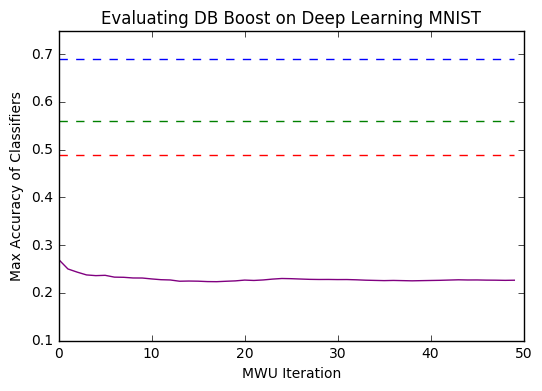

In [9]:
plt.plot(range(50), [fgm_acc] * 50, linestyle='--', color='blue', label='FGM')
plt.plot(range(50), [madry_acc] * 50, linestyle='--', color='red', label='Madry')
plt.plot(range(50), [mim_acc] * 50, linestyle='--', color='green', label='Momentum Iterative Method ')
plt.plot(range(50), mwu_accs, color='purple', label='DB Boost - PGD Nonconvex Hinge')
# plt.legend(fontsize=9,bbox_to_anchor=(1.0, 0.55))
plt.ylabel("Max Accuracy of Classifiers")
plt.xlabel("MWU Iteration")
plt.title('Evaluating DB Boost on Deep Learning MNIST')
plt.ylim(.1,.75)
plt.savefig('dl_mnist_boosting.png')